![Crisp](img/logo.png)
# <img src="img/Blueprints-Pricing Elasticity.png" alt="icon" width="40"/>  Price Elasticity Estimation

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_price_elasticity.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/blob/main/notebooks/crisp_price_elasticity.ipynb)
[![Open in Databricks](https://img.shields.io/badge/Try-databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_price_elasticity.ipynb)

> To deploy a notebook in Databricks:
> 1. Open your workspace and navigate to the folder where you want to import the notebook.
> 2. Click the triple-dot icon (next to the Share button).
> 3. Select **Import**, then choose **URL** as the import method.
> 4. Paste the notebook's URL, then click **Import** to complete the process.

## Introduction
This notebook performs a comprehensive price elasticity analysis for retail products using statistical methods. It combines sales data, pricing information, and product details to understand how price changes affect consumer demand and purchasing behavior. The analysis leverages Bayesian statistical modeling to provide robust insights into price sensitivity across different products.

Analysis steps:
1. Load and prepare retail sales data
2. Implement statistical models for elasticity estimation
3. Compare price elasticities across different sub-categories and products

The notebook utilizes statistical packages including numpyro for Bayesian analysis, along with comprehensive data visualization tools to present findings effectively. This analysis helps retailers optimize pricing strategies by understanding the relationship between price changes and sales performance.


## Understanding Price Elasticity

Price elasticity measures how sensitive customer demand is to changes in price. In simple terms, it tells us how much the quantity sold will change when we change the price. This is crucial for businesses to make informed pricing decisions.

## The Basic Model

The relationship between price and quantity can be modeled as:

$Q = k \cdot P^{\varepsilon}$

Where:
- Q is the quantity sold
- P is the price
- ${\varepsilon}$ is the price elasticity
- k is a constant

## Making it Linear

This equation can be transformed into a linear form by taking the natural logarithm of both sides:

$\ln(Q) = \ln(k) + {\varepsilon} \cdot \ln(P)$

This linear form is much easier to work with. Now we can see that:
- The slope of the line (${\varepsilon}$) is our price elasticity
- When ${\varepsilon}$ < -1: Demand is elastic (price increase / decrease causes decrease / increase in revenue)
- When ${\varepsilon}$ > -1: Demand is inelastic (price increase / decrease causes increase / idecrease in revenue)

## Real World Example

Let's say we have a product with an elasticity of -2. This means:
- A 10% price increase would lead to a 20% decrease in quantity sold
- A 10% price decrease would lead to a 20% increase in quantity sold

This simple model helps businesses understand how to price their products to maximize revenue while considering customer sensitivity to price changes.



## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "999998"
# os.environ["CONNECTOR_ID"] = "7240"
retailer = "target"
category = "Phones & Tablets"

### Run Crisp common

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables that are used across Crisp notebooks.

In [ ]:
if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import jax.numpy as jnp
from jax import random as jrandom
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import reparam
from numpyro.infer import MCMC, NUTS
from numpyro.infer.autoguide import Predictive
from numpyro.infer.reparam import LocScaleReparam
import arviz as az
import seaborn as sns

### Load necessary data
In this section, we'll load and prepare our sales data for analysis. The dataset contains:
 - Store information
 - Product details
 - Sales dollar amounts and quantities

 We'll focus on the last year of sales data, aggregating it by week and product to create
 weekly product-level sales metrics. This aggregation level provides a good balance between
 detail and noise reduction, though more granular data can be used for specific use cases.

In [4]:
# Define table names for queries
dim_product = "exp_harmonized_retailer_dim_product"
dim_store = "exp_harmonized_retailer_dim_store"
fact_sales = "exp_harmonized_retailer_fact_sales"
src_project = project
src_dataset = dataset

# Set date range for analysis
start_date = pd.to_datetime("2023-01-01")  # Set start date for the analysis
end_date = start_date + pd.Timedelta(weeks=156)  # Set number of weeks for analysis
start_date_sql = start_date.strftime("'%Y-%m-%d'")
end_date_sql = end_date.strftime("'%Y-%m-%d'")

In [5]:
%%load sales_df
WITH
  fact_sales AS(
  SELECT
    DATE_TRUNC(CAST(date_key AS DATE), WEEK(MONDAY)) AS date_key, -- We will aggregate by week, starting on Monday
    store_id,
    product_id,
    sales_quantity,
    sales_amount
    FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}`
  WHERE
    retailer = '{retailer}'
    AND CAST(date_key AS DATE) BETWEEN {start_date_sql}
    AND {end_date_sql}
    ),
  products AS (
  SELECT
    product_id,
    product,
    product_category,
    product_sub_category
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_product}`
  WHERE
    retailer = '{retailer}'
    AND product_category = '{category}' )
SELECT
  s.date_key,
  p.product,
  p.product_category,
  p.product_sub_category,
  SUM(s.sales_quantity) AS sales_quantity,
  SUM(s.sales_amount) AS sales_amount,
  CASE 
      WHEN SUM(s.sales_quantity) > 0 THEN SUM(s.sales_amount) / SUM(s.sales_quantity)
      ELSE NULL 
  END AS price
FROM
  fact_sales s
JOIN
  products p
ON
  s.product_id = p.product_id
GROUP BY
  1, 2, 3, 4
ORDER BY date_key, product

,date_key,product,product_category,product_sub_category,sales_quantity,sales_amount,price
0,2022-12-26,LunaBook Infinity,Phones & Tablets,Tablets,1142,42265.42,37.01
1,2022-12-26,LunaPhone Axis,Phones & Tablets,Smartphones,1770,19824.00,11.20
2,2022-12-26,LunaPhone Edge,Phones & Tablets,Smartphones,4723,84966.77,17.99
3,2022-12-26,LunaPhone Helios,Phones & Tablets,Smartphones,1239,28125.30,22.70
4,2022-12-26,LunaPhone Ion,Phones & Tablets,Smartphones,1283,13728.10,10.70
...,...,...,...,...,...,...,...
2115,2024-12-30,LunaTab Ultra,Phones & Tablets,Tablets,1770,24549.90,13.87
2116,2024-12-30,LunaTab X,Phones & Tablets,Tablets,531,24877.35,46.85
2117,2024-12-30,LunaTech Pad,Phones & Tablets,Tablets,2292,37061.64,16.17
2118,2024-12-30,LunaTech Slate,Phones & Tablets,Tablets,6087,31774.14,5.22


### Perform simple preprocessing steps

In [ ]:
# Clean data by removing NANs, negative sales and negative prices
sales_df = sales_df.dropna().copy()

sales_df = sales_df.apply(pd.to_numeric, errors="ignore")

# Convert date_key to datetime
sales_df["date_key"] = pd.to_datetime(sales_df["date_key"])

# Filter for positive sales quantity and price
sales_df = sales_df[(sales_df["sales_quantity"] > 0) & (sales_df["price"] > 0)]

# Remove data from the first and last week to avoid incomplete data
earliest_date = sales_df["date_key"].min()
latest_date = sales_df["date_key"].max()
sales_df = sales_df[
    (sales_df["date_key"] > earliest_date) & (sales_df["date_key"] < latest_date)
]

# Filter out products with no sales in the last 52 weeks
last_52_weeks = pd.Timedelta(weeks=52)
cutoff_date = latest_date - last_52_weeks
active_products = sales_df[sales_df["date_key"] >= cutoff_date]["product"].unique()
sales_df = sales_df[sales_df["product"].isin(active_products)]

To capture underlying product trends not explained by our model variables, we'll create a continuous time index by mapping each week to a sequential number. This "trend" variable will help us account for unobserved factors affecting product performance over time.

In [7]:
# Get the min and max dates
min_date = pd.to_datetime(sales_df["date_key"]).min()
max_date = pd.to_datetime(sales_df["date_key"]).max()

# Create a complete range of weeks from min to max date
all_weeks = pd.date_range(start=min_date, end=max_date, freq="W-MON")

# Create a mapping dictionary from date to week number
week_mapping = {date: i for i, date in enumerate(all_weeks)}

# Map the dates to week numbers
sales_df["time_stamp"] = pd.to_datetime(sales_df["date_key"]).map(week_mapping)

In [8]:
# # Select a subsample of 5 products to accelerate analysis
# # Randomly select 5 unique product IDs
# random_products = sales_df['product_id'].unique()
# np.random.seed(42)  # For reproducibility
# selected_products = np.random.choice(random_products, size=5, replace=False)

# # Filter the dataframe to keep only the selected products
# sales_df = sales_df[sales_df['product_id'].isin(selected_products)]

# sales_df

### Data Exploration: Price and Sales Analysis
 
We analyze the dataset through two key visualizations:
1. Time series analysis showing price and sales quantitymover time (we will do this for the total aggregated sales and 5 random products )
2. Simple correlation analysis between price and sales quantity

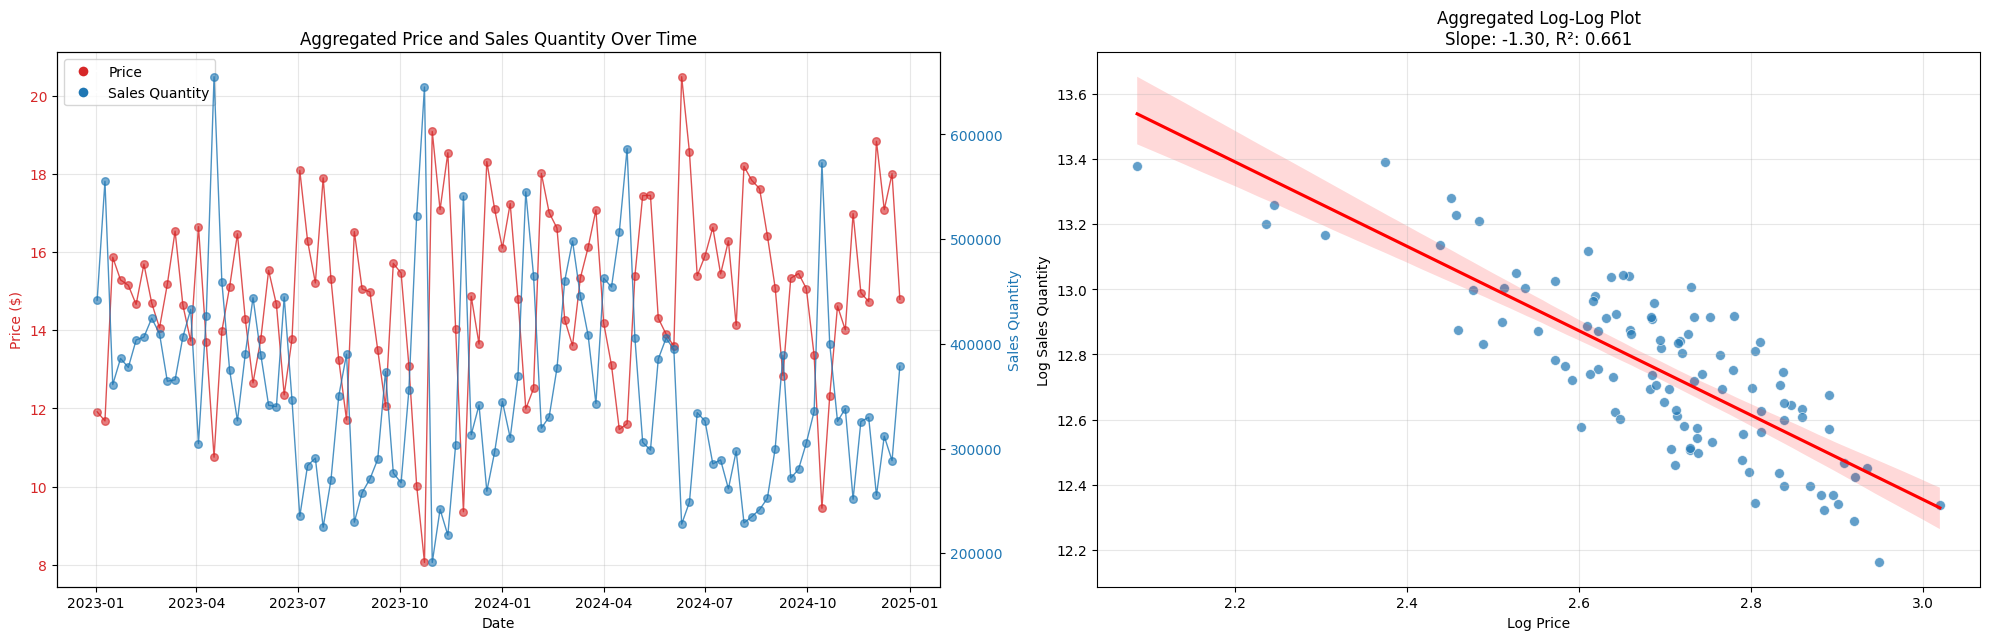

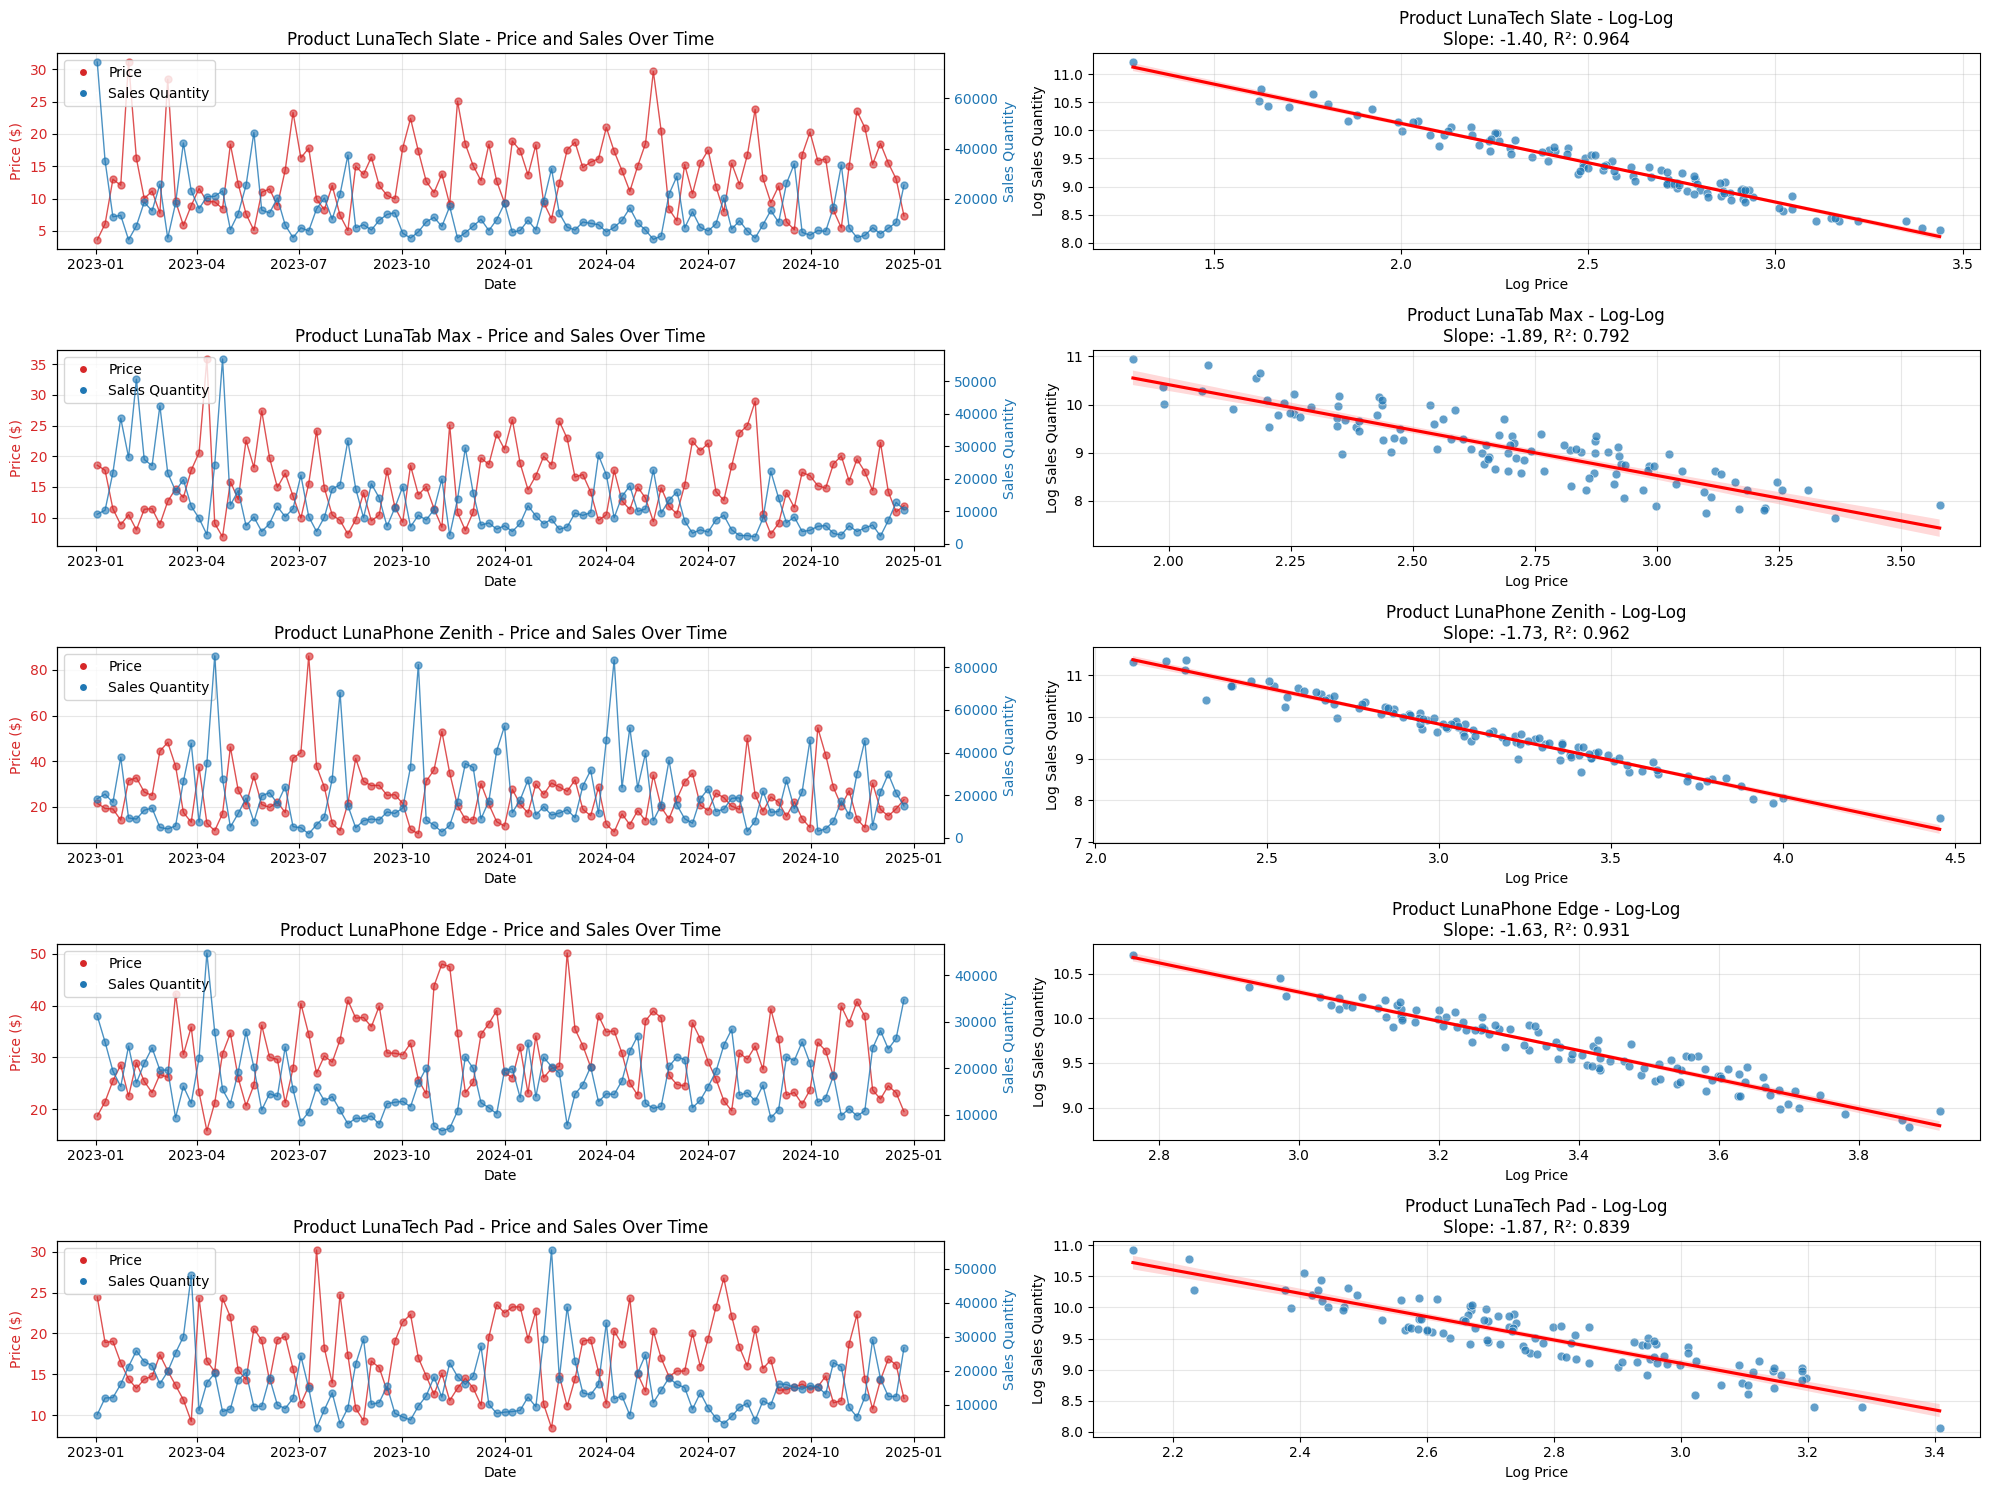

In [9]:
# Aggregate sales data by date
agg_df = sales_df.groupby(["date_key"]).agg(
    {"sales_quantity": "sum", "sales_amount": "sum"}
)
agg_df["price"] = agg_df["sales_amount"] / agg_df["sales_quantity"]

# Create visualization for aggregated data
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Prepare time series data
agg_df_reset = agg_df.reset_index()
if not pd.api.types.is_datetime64_any_dtype(agg_df_reset["date_key"]):
    agg_df_reset["date_key"] = pd.to_datetime(agg_df_reset["date_key"])
agg_df_reset = agg_df_reset.sort_values("date_key")

# Plot time series of price and sales
color1 = "tab:red"
ax1.scatter(
    agg_df_reset["date_key"],
    agg_df_reset["price"],
    color=color1,
    alpha=0.6,
    s=30,
    label="Price",
)
ax1.plot(
    agg_df_reset["date_key"],
    agg_df_reset["price"],
    color=color1,
    linewidth=1,
    alpha=0.8,
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Price ($)", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)

# Add sales quantity on secondary axis
ax1_twin = ax1.twinx()
color2 = "tab:blue"
ax1_twin.scatter(
    agg_df_reset["date_key"],
    agg_df_reset["sales_quantity"],
    color=color2,
    alpha=0.6,
    s=30,
    label="Sales Quantity",
)
ax1_twin.plot(
    agg_df_reset["date_key"],
    agg_df_reset["sales_quantity"],
    color=color2,
    linewidth=1,
    alpha=0.8,
)

ax1_twin.set_ylabel("Sales Quantity", color=color2)
ax1_twin.tick_params(axis="y", labelcolor=color2)

ax1.set_title("Aggregated Price and Sales Quantity Over Time")
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color1,
        markersize=8,
        label="Price",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color2,
        markersize=8,
        label="Sales Quantity",
    ),
]
ax1.legend(handles=legend_elements, loc="upper left")
ax1.grid(True, alpha=0.3)

# Create log-log plot with regression line
log_price = np.log(agg_df["price"])
log_quantity = np.log(agg_df["sales_quantity"])
log_df = pd.DataFrame({"log_price": log_price, "log_quantity": log_quantity})

sns.scatterplot(data=log_df, x="log_price", y="log_quantity", alpha=0.7, s=50, ax=ax2)
sns.regplot(
    data=log_df, x="log_price", y="log_quantity", scatter=False, ax=ax2, color="red"
)

# Calculate and display regression statistics
X = log_price.values.reshape(-1, 1)
y = log_quantity.values
reg = LinearRegression().fit(X, y)
slope = reg.coef_[0]
r_squared = reg.score(X, y)

ax2.set_xlabel("Log Price")
ax2.set_ylabel("Log Sales Quantity")
ax2.set_title(f"Aggregated Log-Log Plot\nSlope: {slope:.2f}, R²: {r_squared:.3f}")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create visualizations for 5 random products
random_products = np.random.choice(sales_df["product"].unique(), size=5, replace=False)
fig2 = plt.figure(figsize=(20, 15))
gs2 = fig2.add_gridspec(5, 2)

for idx, product in enumerate(random_products):
    product_data = sales_df[sales_df["product"] == product].copy()

    if not pd.api.types.is_datetime64_any_dtype(product_data["date_key"]):
        product_data["date_key"] = pd.to_datetime(product_data["date_key"])
    product_data = product_data.sort_values("date_key")

    # Time series plot
    ax3 = fig2.add_subplot(gs2[idx, 0])
    color1 = "tab:red"
    ax3.scatter(
        product_data["date_key"],
        product_data["price"],
        color=color1,
        alpha=0.6,
        s=25,
        label="Price",
    )
    ax3.plot(
        product_data["date_key"],
        product_data["price"],
        color=color1,
        linewidth=1,
        alpha=0.8,
    )

    ax3.set_xlabel("Date")
    ax3.set_ylabel("Price ($)", color=color1)
    ax3.tick_params(axis="y", labelcolor=color1)

    ax3_twin = ax3.twinx()
    color2 = "tab:blue"
    ax3_twin.scatter(
        product_data["date_key"],
        product_data["sales_quantity"],
        color=color2,
        alpha=0.6,
        s=25,
        label="Sales Quantity",
    )
    ax3_twin.plot(
        product_data["date_key"],
        product_data["sales_quantity"],
        color=color2,
        linewidth=1,
        alpha=0.8,
    )

    ax3_twin.set_ylabel("Sales Quantity", color=color2)
    ax3_twin.tick_params(axis="y", labelcolor=color2)

    ax3.set_title(f"Product {product} - Price and Sales Over Time")
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=color1,
            markersize=6,
            label="Price",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=color2,
            markersize=6,
            label="Sales Quantity",
        ),
    ]
    ax3.legend(handles=legend_elements, loc="upper left")
    ax3.grid(True, alpha=0.3)

    # Log-log plot
    ax4 = fig2.add_subplot(gs2[idx, 1])
    log_price = np.log(product_data["price"])
    log_quantity = np.log(product_data["sales_quantity"])
    product_log_df = pd.DataFrame(
        {"log_price": log_price, "log_quantity": log_quantity}
    )

    sns.scatterplot(
        data=product_log_df, x="log_price", y="log_quantity", alpha=0.7, s=40, ax=ax4
    )
    sns.regplot(
        data=product_log_df,
        x="log_price",
        y="log_quantity",
        scatter=False,
        ax=ax4,
        color="red",
    )

    X = log_price.values.reshape(-1, 1)
    y = log_quantity.values
    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0]
    r_squared = reg.score(X, y)

    ax4.set_xlabel("Log Price")
    ax4.set_ylabel("Log Sales Quantity")
    ax4.set_title(
        f"Product {product} - Log-Log\nSlope: {slope:.2f}, R²: {r_squared:.3f}"
    )
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Modeling Phase
 In this section, we'll use hierarchical Bayesian regression to estimate price elasticities. Here's why this approach is powerful:
 
 - `Hierarchical Modeling`: Instead of treating each product independently, we'll model them as part of a larger group (like product sub-categories). This means products with less data can "borrow strength" from similar products, leading to more reliable estimates.

 - `Why Bayesian?`: Unlike traditional methods, Bayesian analysis gives us full probability distributions for our estimates, not just point estimates. This means we can quantify our uncertainty about each product's price elasticity.
 
We will use a packaged called NumPyro that is well-suited for hierarchical models. It automatically handles the complex calculations needed for Bayesian inference.

First we will filter the data to only products with meanigful amount of data to be analyzed as well as with meaningful price variations.

In [10]:
# Count unique weeks and prices per product
product_stats = (
    sales_df.groupby("product")
    .agg({"date_key": "nunique", "price": "nunique"})
    .reset_index()
)

# Filter products with at least 10 unique weeks of sales and 10 unique price values
valid_products = product_stats[
    (product_stats["date_key"] >= 10) & (product_stats["price"] >= 10)
]["product"]

# Filter the original dataframe to keep only valid products
sales_df = sales_df[sales_df["product"].isin(valid_products)]
sales_df

,date_key,product,product_category,product_sub_category,sales_quantity,sales_amount,price,time_stamp
20,2023-01-02,LunaBook Infinity,Phones & Tablets,Tablets,11309,312176.17,27.604224,0
21,2023-01-02,LunaPhone Axis,Phones & Tablets,Smartphones,11682,136332.48,11.670303,0
22,2023-01-02,LunaPhone Edge,Phones & Tablets,Smartphones,31311,584999.53,18.683515,0
23,2023-01-02,LunaPhone Helios,Phones & Tablets,Smartphones,7613,182656.02,23.992647,0
24,2023-01-02,LunaPhone Ion,Phones & Tablets,Smartphones,9248,98302.47,10.629592,0
...,...,...,...,...,...,...,...,...
2095,2024-12-23,LunaTab Ultra,Phones & Tablets,Tablets,8850,139688.40,15.784000,103
2096,2024-12-23,LunaTab X,Phones & Tablets,Tablets,22990,431521.18,18.769951,103
2097,2024-12-23,LunaTech Pad,Phones & Tablets,Tablets,26707,322117.15,12.061151,103
2098,2024-12-23,LunaTech Slate,Phones & Tablets,Tablets,25459,186394.23,7.321349,103


In [11]:
# We check the number of unique products and dates
print(f"Number of unique products: {sales_df['product'].nunique()}")
print(f"Number of unique weeks: {sales_df['date_key'].nunique()}")

Number of unique products: 20
Number of unique weeks: 104


We will prepare our training dataset for modeling price elasticities. Since price elasticity is measured as the linear coefficient in a log-log relationship between sales quantity and price, we will create log-transformed features for both variables.

In [12]:
train = sales_df.copy()
train["log_quantity"] = np.log(train["sales_quantity"])
train["log_price"] = np.log(train["price"])

# Select and reorder columns
train = train[
    [
        "date_key",
        "product",
        "product_sub_category",
        "time_stamp",
        "log_quantity",
        "log_price",
    ]
]
train

,date_key,product,product_sub_category,time_stamp,log_quantity,log_price
20,2023-01-02,LunaBook Infinity,Tablets,0,9.333354,3.317969
21,2023-01-02,LunaPhone Axis,Smartphones,0,9.365804,2.457047
22,2023-01-02,LunaPhone Edge,Smartphones,0,10.351725,2.927642
23,2023-01-02,LunaPhone Helios,Smartphones,0,8.937613,3.177747
24,2023-01-02,LunaPhone Ion,Smartphones,0,9.132163,2.363642
...,...,...,...,...,...,...
2095,2024-12-23,LunaTab Ultra,Tablets,103,9.088173,2.758997
2096,2024-12-23,LunaTab X,Tablets,103,10.042815,2.932257
2097,2024-12-23,LunaTech Pad,Tablets,103,10.192681,2.489990
2098,2024-12-23,LunaTech Slate,Tablets,103,10.144825,1.990795


 In our **price elasticity analysis**, we need to account for factors that could influence sales beyond just price changes. These factors help us isolate the true impact of price on sales. Think of it like controlling for variables that could muddy our results.

 For example, some products naturally sell more than others (like popular brands), certain categories might have seasonal patterns, and sales might vary by time period (like holidays). By creating these categorical mappings, we're essentially saying "let's compare products fairly by accounting for some inherent differences."

 We're creating two main categorical variables:
 1. `Product`: To account for product-specific effects
 2. `Product' Subcategory`: To control for sub-category-level patterns
Later we will also use out **time_stamp** to acount for **underlying trends** and **seasonlity**.

 These mappings will help us get a cleaner picture of how price changes truly affect sales, by removing the influence of these other factors.

In [13]:
# Create mappings for categorical variables

# Initialize label encoders
le_product = LabelEncoder()
le_sub_category = LabelEncoder()

# Create week time stamp
week_t_obs = np.array(train["time_stamp"])

# Transform categorical variables
obs_idx = np.arange(train.shape[0])
product_idx = jnp.array(le_product.fit_transform(train["product"]))
product = le_product.classes_
product_sub_category_idx = jnp.array(
    le_sub_category.fit_transform(train["product_sub_category"])
)
product_sub_category = le_sub_category.classes_

# Create product to subcategory mapping
product_to_subcategory = (
    train[["product", "product_sub_category"]]
    .drop_duplicates()
    .sort_values(["product", "product_sub_category"])
)
product_to_subcategory["product_idx"] = jnp.array(
    le_product.transform(product_to_subcategory["product"])
)
product_to_subcategory["product_sub_category_idx"] = jnp.array(
    le_sub_category.transform(product_to_subcategory["product_sub_category"])
)
product_to_subcategory_idx = jnp.array(
    product_to_subcategory.sort_values("product_idx")["product_sub_category_idx"]
)

# Extract numeric features
# Normalize price mean to 0
log_price = jnp.array(train["log_price"] - train["log_price"].mean())
log_quantity = jnp.array(train["log_quantity"])

# Print shapes to verify dimensions
print("Shapes of transformed data:")
print(f"obs_idx: {obs_idx.shape}")
print(f"week_t_obs: {week_t_obs.shape}")
print(f"product_idx: {product_idx.shape}")
print(f"product_sub_category_idx: {product_sub_category_idx.shape}")
print(f"log_price: {log_price.shape}")
print(f"log_quantity: {log_quantity.shape}")

Shapes of transformed data:
obs_idx: (2080,)
week_t_obs: (2080,)
product_idx: (2080,)
product_sub_category_idx: (2080,)
log_price: (2080,)
log_quantity: (2080,)


We'll use a `hierarchical Bayesian model` to estimate price elasticities. This approach is powerful because it:
1. **Groups similar products together (sub-categories) to share information**
2. **Allows individual products to have their own unique price sensitivity**
3. **Uses prior knowledge to guide the model's learning**

The model has two levels:
- `Sub-category level`: Groups similar products
- `Product level`: Individual products within each group

A key advantage of Bayesian modeling is using prior knowledge. In our case, we know that:
- **Price elasticities should be negative (higher prices → lower sales)**
- **We will assume as prior knowledge most products have moderate price sensitivity (`~ -1`)**
- **Products in same sub-category tend to have similar price sensitivity**

This prior knowledge helps the model make better estimates, especially when we have limited data for some products.

#### Below we define our model structure:
For simplicity we will assume that every product in the category follows a similar seasonal pattern. This assumption simplifies the model and facilitates convergence. We will create two seasonal components to be used in the model (two components are flexible enough to capture the overall yearly seasonality)

In [14]:
# week_t_obs is our array of week numbers for each observation
# and there are 52 weeks in a year
period = np.array(52.0)
sin_yearly_obs = np.sin(2 * np.pi * week_t_obs / period)
cos_yearly_obs = np.cos(2 * np.pi * week_t_obs / period)

Below we define parameters we will be using in the model. These are needed for prior setting and for numpyro to function properly

In [15]:
# Number of unique sub-categories in the data
n_sub = np.unique(product_sub_category_idx).size

# Number of unique products in the data
n_prod = np.unique(product_idx).size

# Total number of observations (price-quantity pairs)
n_obs = log_price.size

# Location parameter for the product intercept prior - using mean of log quantities
# This centers our prior belief about product-specific baseline sales
intercept_prior_loc = log_quantity.mean()

# Scale parameter for the product intercept prior - using standard deviation of log quantities
# This determines how much we expect product-specific baseline sales to vary
intercept_prior_scale = log_quantity.std()

##### Now we set our model
We give the model a few **common-sense starting beliefs**, which are our built in ssumptions, or `"priors"`:

`Elasticities are Negative:` We've built in a rule that if a price goes up, sales should go down. The model is not allowed to find a result where raising the price increases sales.

`Products in a Group are Related:` The model starts with the assumption that products in the same sub-category are likely to have similar (though not identical) elasticities.

`Trends are Generally Small:` It assumes products don't suddenly become massively more or less popular from one week to the next without a good reason.

`The Final Result:` **An Estimate with Uncertainty**
Instead of giving just one number for each product's elasticity (like "-1.5"), the model gives us a range of plausible values and a "best guess" (the mean or median).

For example, it might conclude: "For Product X, our best estimate for the elasticity is -1.5, and we are 90% confident the true value is between -1.2 and -1.8."

This range (the "error bar" or credible interval) is crucial. A wide range means the data for that product wasn't very clear, so we are less certain. A narrow range means we have a very precise estimate.

In [16]:
def price_elasticity_model(
    product_idx,
    product_to_subcategory_idx,
    week_t_obs,
    sin_yearly_obs,
    cos_yearly_obs,
    log_price,
    n_prod,
    n_sub,
    n_obs,
    intercept_prior_loc,
    intercept_prior_scale,
    log_quantity=None,
):
    """
    Bayesian hierarchical model to estimate product-level price elasticities with
    product-specific trends and global seasonality.

    Parameters
    ----------
    product_idx : array-like
        Array of indices mapping each observation to its corresponding product
    product_to_subcategory_idx : array-like
        Array mapping each product to its subcategory
    week_t_obs : array-like
        Array of week numbers for each observation (used for trend and seasonality)
    sin_yearly_obs : array-like
        Sine component of yearly seasonality for each observation
    cos_yearly_obs : array-like
        Cosine component of yearly seasonality for each observation
    log_price : array-like
        Natural logarithm of price for each observation
    n_prod : int
        Number of unique products in the dataset
    n_sub : int
        Number of unique sub-categories in the dataset
    n_obs : int
        Total number of observations (price-quantity pairs) in the dataset
    intercept_prior_loc : float
        Location parameter for the product intercept prior (mean of log quantities)
    intercept_prior_scale : float
        Scale parameter for the product intercept prior (std of log quantities)
    log_quantity : array-like, optional
        Natural logarithm of quantity sold for each observation. If None, model runs in predictive mode.
    """

    # === Hyperpriors for Elasticity Hierarchy ===
    # Priors for the global distribution of sub-category 'raw' elasticities (log-magnitude scale)
    # In here raw_mu_sub_cat_mean_hyper is the mean of the sub-category elasticities
    # raw_mu_sub_cat_scale_hyper is the scale of the sub-category elasticities
    # raw_prod_el_scale_within_sub_hyper is the scale of the product elasticities within the sub-category
    raw_mu_sub_cat_mean_hyper = numpyro.sample(
        "raw_mu_sub_cat_mean_hyper", dist.Normal(0.0, 0.5)
    )
    raw_mu_sub_cat_scale_hyper = numpyro.sample(
        "raw_mu_sub_cat_scale_hyper", dist.HalfNormal(0.5)
    )
    raw_prod_el_scale_within_sub_hyper = numpyro.sample(
        "raw_prod_el_scale_within_sub_hyper", dist.HalfNormal(0.5)
    )

    # === Sub-category Level Parameters ===
    with numpyro.plate("sub", n_sub):
        # Sub-category characteristic 'raw' elasticity (log-magnitude)
        raw_mu_for_this_sub_cat = numpyro.sample(
            "raw_mu_for_this_sub_cat",
            dist.Normal(raw_mu_sub_cat_mean_hyper, raw_mu_sub_cat_scale_hyper),
        )
        # Interpretable, negative sub-category elasticity
        numpyro.deterministic(
            "sub_category_elasticity", -jnp.exp(raw_mu_for_this_sub_cat)
        )
        # Scale of product 'raw' elasticity variation within this sub-category
        raw_scale_for_products_in_this_sub = numpyro.sample(
            "raw_scale_for_products_in_this_sub",
            dist.HalfNormal(raw_prod_el_scale_within_sub_hyper),
        )

    # === Global & Product Level Parameters ===
    # Priors for the global distribution of product intercepts
    global_intercept_mean = numpyro.sample(
        "global_intercept_mean", dist.Normal(intercept_prior_loc, intercept_prior_scale)
    )
    global_intercept_scale = numpyro.sample(
        "global_intercept_scale", dist.HalfNormal(intercept_prior_scale)
    )
    # Hyperprior for product-specific observation noise
    sigma_product_obs_hyper_scale = numpyro.sample(
        "sigma_product_obs_hyper_scale", dist.HalfNormal(0.5)
    )
    # Hyperprior for the scale of product-specific trend slopes
    trend_slope_prior_scale = numpyro.sample(
        "trend_slope_prior_scale", dist.HalfNormal(0.01)
    )

    # Global seasonal coefficients for common yearly seasonality
    global_sin_coeff = numpyro.sample("global_sin_coeff", dist.Normal(0.0, 0.5))
    global_cos_coeff = numpyro.sample("global_cos_coeff", dist.Normal(0.0, 0.5))

    with numpyro.plate("products", n_prod):
        # Product Intercept (hierarchical)
        product_intercept = numpyro.sample(
            "product_intercept",
            dist.Normal(loc=global_intercept_mean, scale=global_intercept_scale),
        )

        # Product Elasticity (hierarchical, derived from raw value)
        product_s_raw_mu_loc = raw_mu_for_this_sub_cat[product_to_subcategory_idx]
        product_s_raw_scale = raw_scale_for_products_in_this_sub[
            product_to_subcategory_idx
        ]
        raw_product_el = numpyro.sample(
            "raw_product_el",
            dist.Normal(loc=product_s_raw_mu_loc, scale=product_s_raw_scale),
        )
        product_elasticity = numpyro.deterministic(
            "product_elasticity", -jnp.exp(raw_product_el)
        )

        # Product-specific observation noise sigma (hierarchical)
        sigma_product_specific_obs = numpyro.sample(
            "sigma_product_specific_obs", dist.HalfNormal(sigma_product_obs_hyper_scale)
        )

        # Product-specific trend slope (hierarchical)
        product_trend_slope = numpyro.sample(
            "product_trend_slope", dist.Normal(0.0, trend_slope_prior_scale)
        )

    # === Observation Level Calculations ===
    # Calculate effect components for each observation
    trend_effect_obs = product_trend_slope[product_idx] * week_t_obs
    seasonality_effect_obs = (
        global_sin_coeff * sin_yearly_obs + global_cos_coeff * cos_yearly_obs
    )

    # Calculate mu (the mean of log_quantity)
    mu = (
        product_intercept[product_idx]
        + product_elasticity[product_idx] * log_price
        + trend_effect_obs
        + seasonality_effect_obs
    )
    mu_deterministic = numpyro.deterministic("mu", mu)

    # Assign correct observation noise for each observation
    sigma_for_likelihood = sigma_product_specific_obs[product_idx]

    # === Likelihood ===
    with numpyro.plate("observations", n_obs):
        numpyro.sample(
            "obs", dist.Normal(mu_deterministic, sigma_for_likelihood), obs=log_quantity
        )

Next we reparametize our model. Reparameterization is important because it helps the sampler (the engine that finds our results) work more efficiently. Think of it like giving the sampler a better map to navigate a complex landscape; it helps prevent the sampler from getting stuck in difficult areas, which reduces errors and leads to more reliable estimates.

In [17]:
reparam_config = {
    "global_intercept_mean": LocScaleReparam(),
    "product_intercept": LocScaleReparam(),
    "raw_mu_for_this_sub_cat": LocScaleReparam(),
    "raw_product_el": LocScaleReparam(),
    "product_trend_slope": LocScaleReparam(),
    "product_sin_coeff_yearly": LocScaleReparam(),
    "product_cos_coeff_yearly": LocScaleReparam(),
}

reparam_price_elasticity_model = reparam(
    fn=price_elasticity_model, config=reparam_config
)

In [18]:
# Create random keys
main_rng_key = jrandom.PRNGKey(0)
mcmc_rng_key, predictive_rng_key = jrandom.split(main_rng_key)

In [ ]:
# Initialize MCMC for sampling - adjust num_warmup and num_samples to improve convergence
kernel = NUTS(reparam_price_elasticity_model, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=200, num_samples=200, num_chains=2, progress_bar=False)

# Run MCMC
mcmc.run(
    mcmc_rng_key,
    product_idx,
    product_to_subcategory_idx,
    week_t_obs,
    sin_yearly_obs,
    cos_yearly_obs,
    log_price,
    n_prod,
    n_sub,
    n_obs,
    intercept_prior_loc,
    intercept_prior_scale,
    log_quantity=log_quantity,
)

**Model Quality Assessment** \
The MCMC summary below provides key diagnostics for evaluating model convergence and sampling efficiency:
- `n_eff`: Effective sample size - should be at least several hundred for reliable inference
- `r_hat`: - should be < 1.05 to indicate good mixing between chains
- `divergences`: - ideally we see no divergences in the sampling

In [20]:
# Print summary of monte carlo sampling to evaluate convergence
# mcmc.print_summary()

In [21]:
# Get posterior samples. We can use these samples to make inferences about our model parameters and generate predictions.
posterior_samples = mcmc.get_samples()

### Model Assessment
We will evaluate our model's performance through two key analyses:
1. `Distribution Comparison`: We'll generate simulated data from our model's distribution and compare its shape and characteristics with the actual observed data. This helps us verify if our model captures the underlying data patterns correctly.
2. `Prediction Accuracy`: Assess how well the model's predictions align with actual product level time series data.

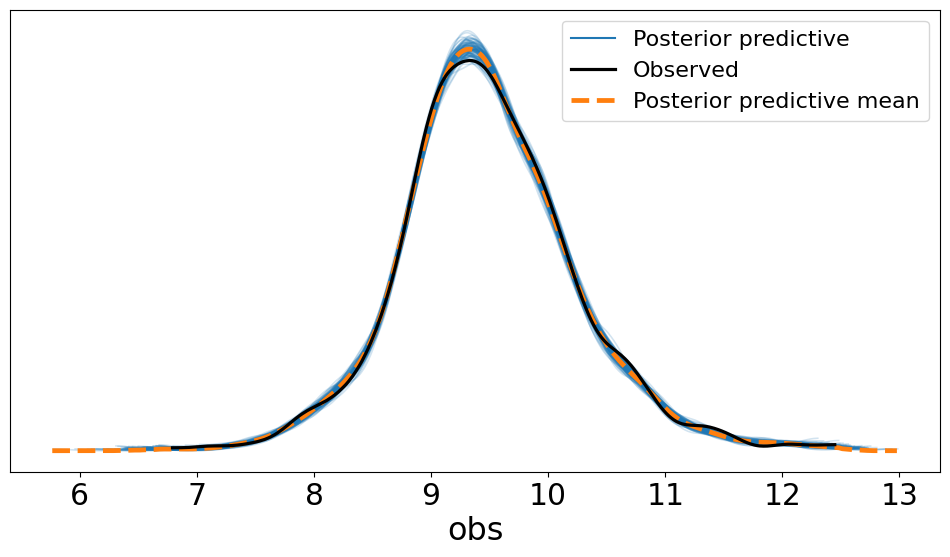

In [22]:
# 1. Distribution Comparison
# Get predictions for all training data points
predictive = Predictive(
    reparam_price_elasticity_model, posterior_samples, return_sites=["obs"]
)

predictions = predictive(
    rng_key=predictive_rng_key,
    product_idx=product_idx,
    product_to_subcategory_idx=product_to_subcategory_idx,
    week_t_obs=week_t_obs,
    sin_yearly_obs=sin_yearly_obs,
    cos_yearly_obs=cos_yearly_obs,
    log_price=log_price,
    n_prod=n_prod,
    n_sub=n_sub,
    n_obs=n_obs,
    intercept_prior_loc=intercept_prior_loc,
    intercept_prior_scale=intercept_prior_scale,
)

idata = az.from_numpyro(mcmc, posterior_predictive=predictions)

# Plotting the distribution of observed log_quantity vs. posterior predictive log_quantity
az.plot_ppc(idata, var_names=["obs"], kind="kde", num_pp_samples=100, figsize=(12, 6))
plt.show()

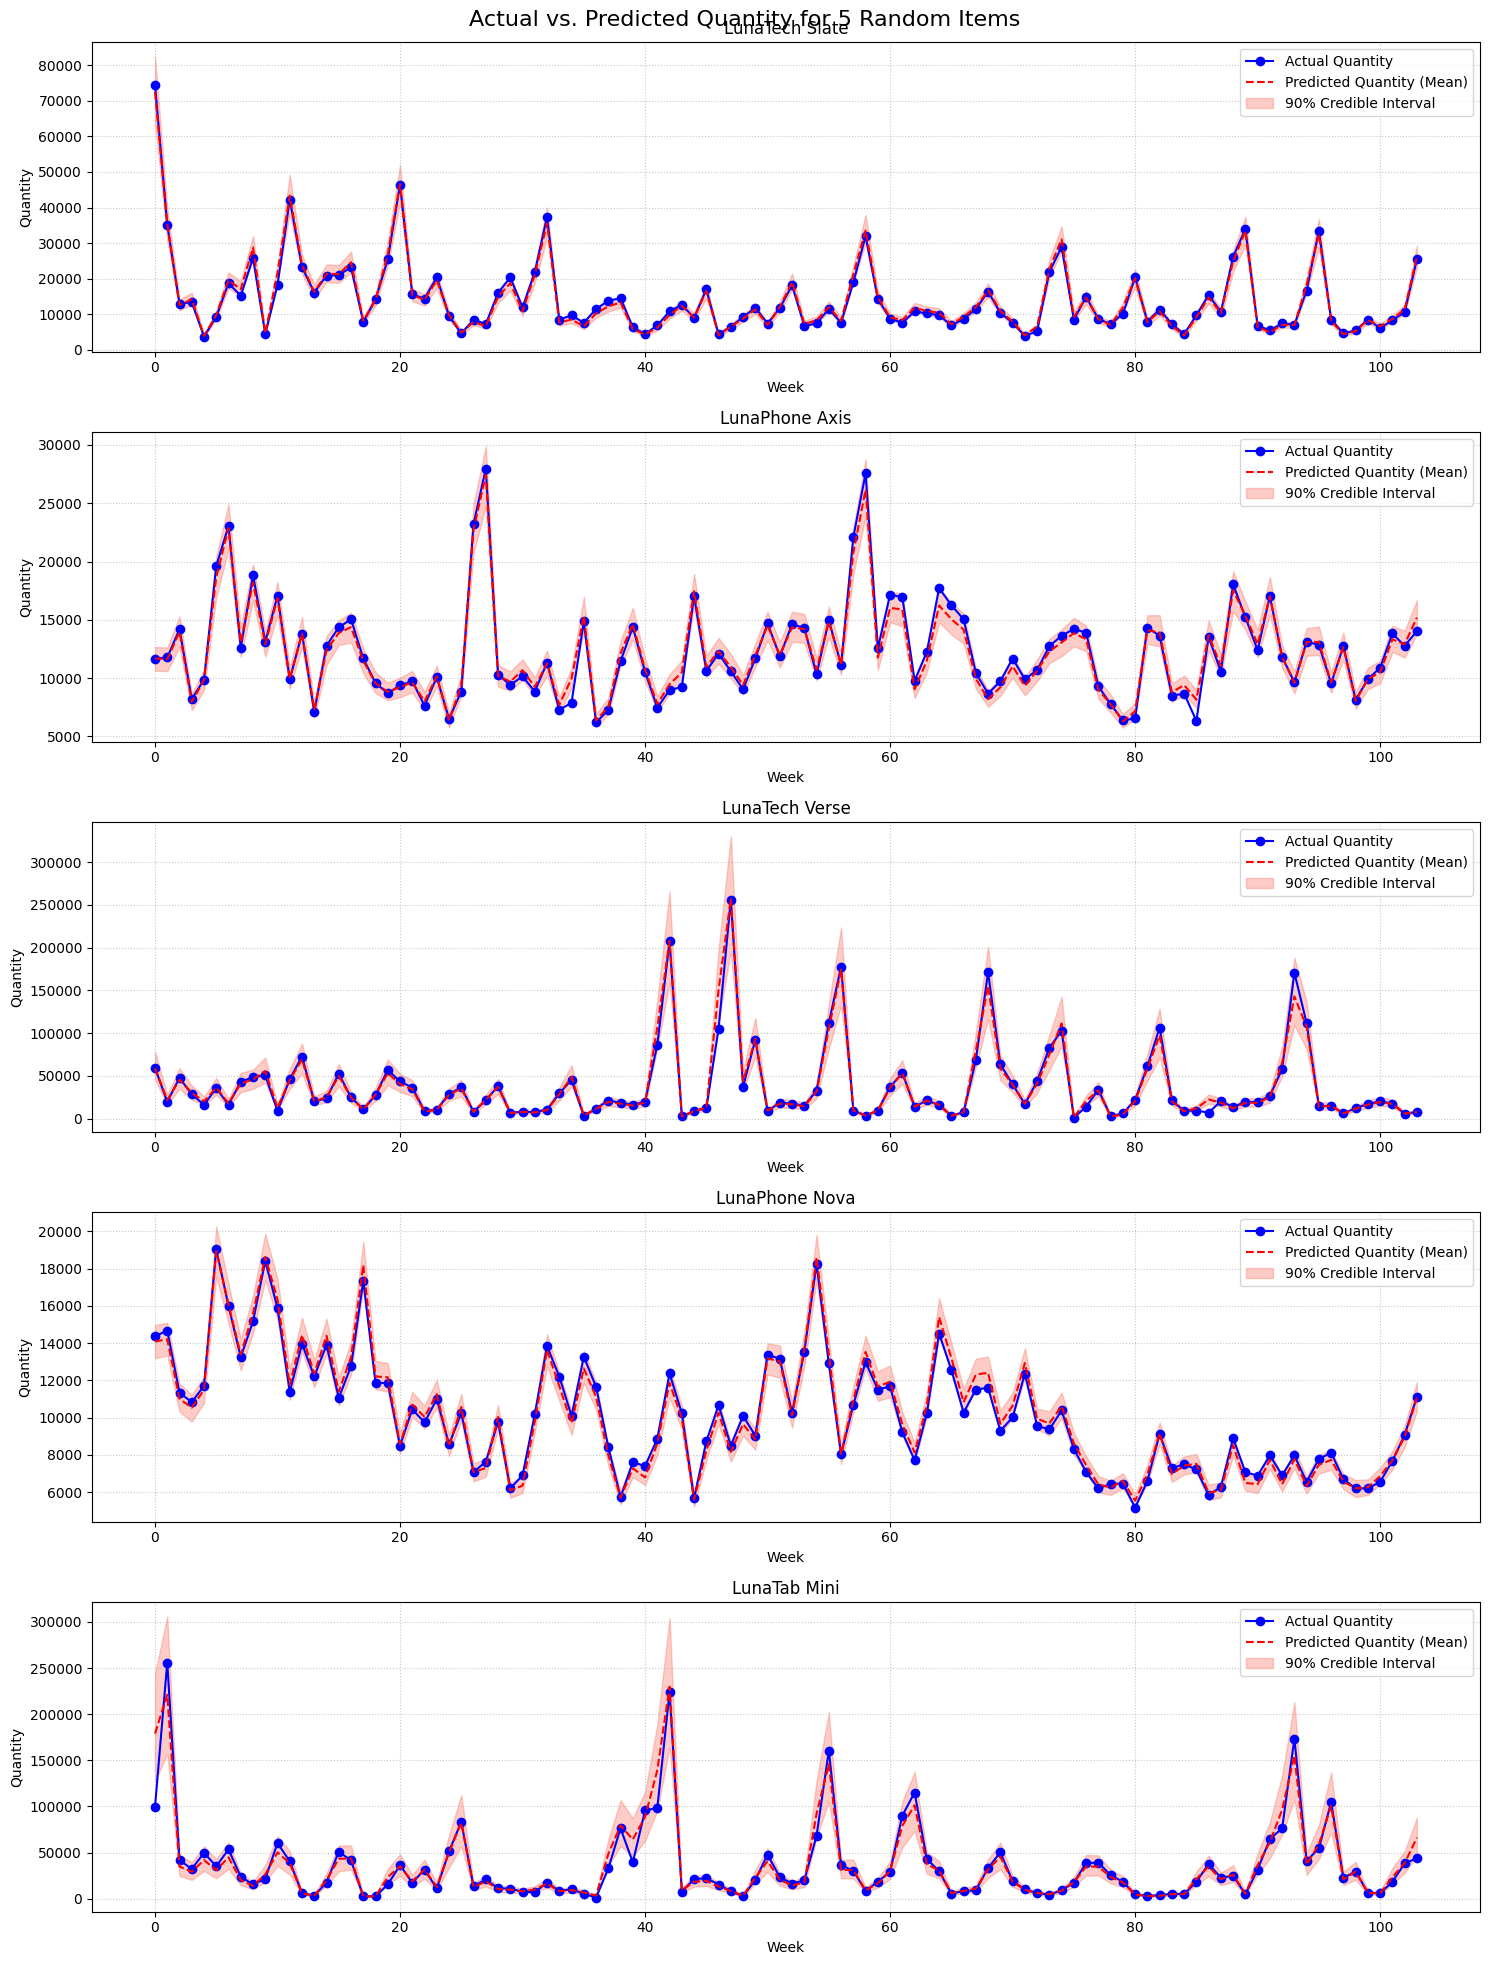

In [23]:
# 2. Prediction Accuracy
# Observed data (log_quantity)
observed_log_quantity = idata.observed_data["obs"].values.flatten()

# Posterior predictive samples (log_quantity)
ppc_log_quantity = idata.posterior_predictive["obs"].values

# Reshape ppc_log_quantity to (total_samples, num_observations)
total_pp_samples = ppc_log_quantity.shape[0] * ppc_log_quantity.shape[1]
num_observations = ppc_log_quantity.shape[2]
ppc_log_quantity_reshaped = ppc_log_quantity.reshape(total_pp_samples, num_observations)

# Convert log_quantity to quantity scale
observed_quantity = np.exp(observed_log_quantity)
ppc_quantity_reshaped = np.exp(ppc_log_quantity_reshaped)

# Create a DataFrame for easy aggregation of observed data
df_observed = pd.DataFrame(
    {
        "week_t": week_t_obs,
        "product_idx": product_idx,
        "actual_quantity": observed_quantity,
    }
)

# Select 5 random items
random_items = np.random.choice(np.unique(product_idx), size=5, replace=False)

# Create subplot for each random item
fig, axes = plt.subplots(5, 1, figsize=(15, 20))
fig.suptitle("Actual vs. Predicted Quantity for 5 Random Items", fontsize=16)

for idx, item in enumerate(random_items):
    # Filter data for current item
    item_data = df_observed[df_observed["product_idx"] == item]
    item_weeks = item_data["week_t"].values
    item_actual = item_data["actual_quantity"].values

    # Get predictions for current item
    item_indices = np.where(product_idx == item)[0]
    item_predictions = ppc_quantity_reshaped[:, item_indices]

    # Calculate mean and credible intervals
    mean_predicted = np.mean(item_predictions, axis=0)
    ci_lower = np.percentile(item_predictions, 5.0, axis=0)
    ci_upper = np.percentile(item_predictions, 95.0, axis=0)

    # Plot
    ax = axes[idx]

    # Plot quantity data
    ax.plot(
        item_weeks,
        item_actual,
        label="Actual Quantity",
        color="blue",
        marker="o",
        linestyle="-",
    )
    ax.plot(
        item_weeks,
        mean_predicted,
        label="Predicted Quantity (Mean)",
        color="red",
        linestyle="--",
    )
    ax.fill_between(
        item_weeks,
        ci_lower,
        ci_upper,
        color="salmon",
        alpha=0.4,
        label="90% Credible Interval",
    )

    # Set labels and title
    ax.set_xlabel("Week")
    ax.set_ylabel("Quantity")
    ax.set_title(f"{product[item]}")  # Use product name instead of index

    # Add legend
    ax.legend(loc="upper right")

    ax.grid(True, linestyle=":", alpha=0.7)

plt.tight_layout()
plt.show()

 ### Price Elasticity Analysis
 We will now evaluate the results of price elasticities for both Subcategories and products. The results will show:

    - Mean elasticities with 90% credible intervals
    - Elastic/Inelastic classification (-1 threshold)
    - Error bar visualization


In [24]:
# 1. Subcategory elasticities table with confidence intervals
subcategory_elasticities = posterior_samples["sub_category_elasticity"]
subcategory_ci = np.percentile(subcategory_elasticities, [5.0, 95.0], axis=0)
subcategory_df = pd.DataFrame(
    {
        "sub_category": list(product_sub_category),
        "mean_elasticity": subcategory_elasticities.mean(axis=0),
        "lower_ci": subcategory_ci[0],
        "upper_ci": subcategory_ci[1],
    }
)

# Add elasticity classification column
subcategory_df["elasticity_type"] = np.where(
    subcategory_df["mean_elasticity"] < -1, "Elastic", "Inelastic"
)

subcategory_df = subcategory_df.sort_values("mean_elasticity", ascending=False)
print("\nSubcategory Price Elasticities with 90% CI:")  # Updated print message
subcategory_df


Subcategory Price Elasticities with 90% CI:


,sub_category,mean_elasticity,lower_ci,upper_ci,elasticity_type
0,Smartphones,-1.648856,-1.771640,-1.541262,Elastic
1,Tablets,-1.679222,-1.870875,-1.506679,Elastic


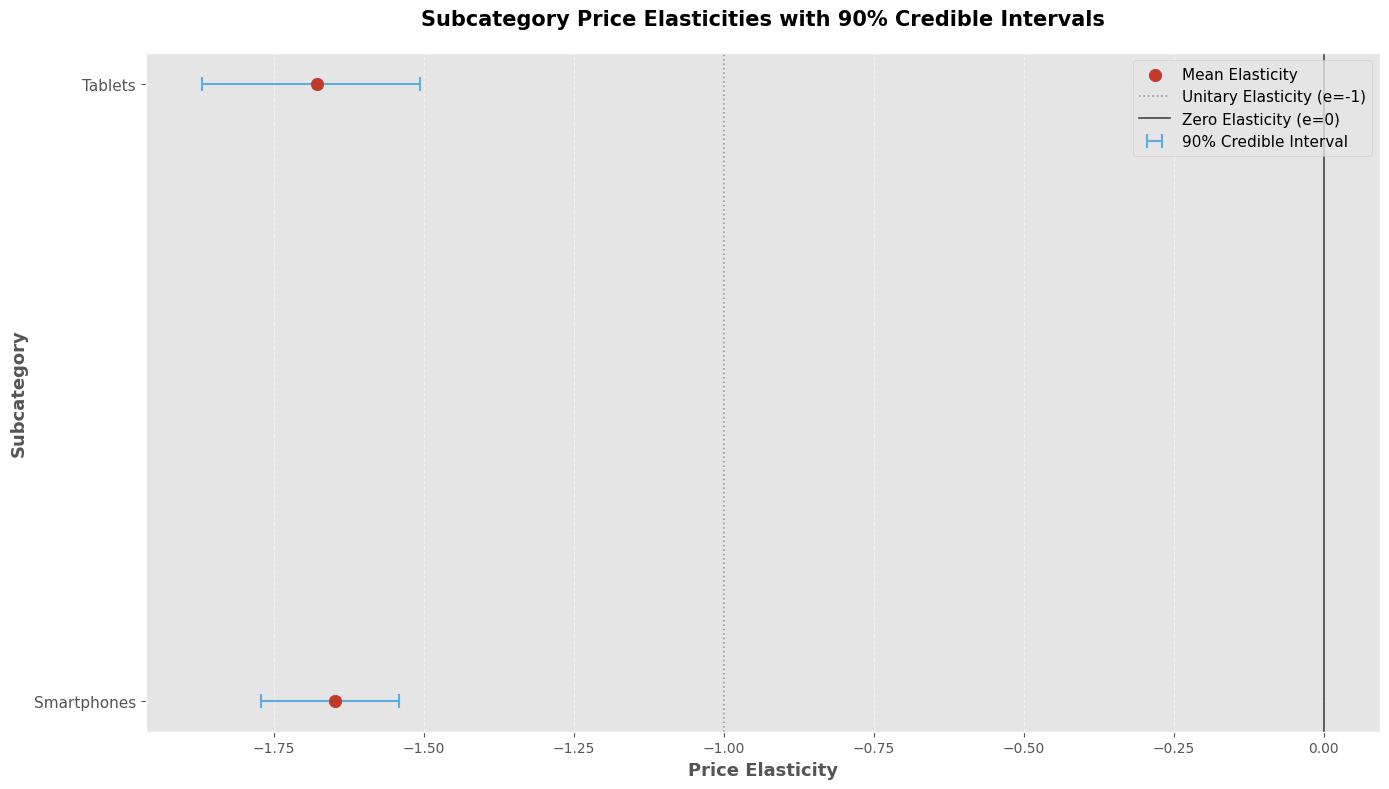

In [25]:
# 2. Subcategory elasticities plot
plt.style.use("ggplot")
plt.figure(figsize=(14, 8))
y_pos = np.arange(len(subcategory_df))

# Calculate asymmetric errors
xerr_lower = subcategory_df["mean_elasticity"] - subcategory_df["lower_ci"]
xerr_upper = subcategory_df["upper_ci"] - subcategory_df["mean_elasticity"]
xerr_asymmetric = [xerr_lower.to_numpy(), xerr_upper.to_numpy()]

plt.errorbar(
    x=subcategory_df["mean_elasticity"],
    y=y_pos,
    xerr=xerr_asymmetric,
    fmt="none",
    capsize=5,
    color="#5dade2",
    elinewidth=1.5,
    capthick=1.5,
    label="90% Credible Interval",
)

plt.scatter(
    x=subcategory_df["mean_elasticity"],
    y=y_pos,
    color="#c0392b",
    s=80,
    label="Mean Elasticity",
    zorder=5,
)

# Reference lines
plt.axvline(
    x=-1,
    color="grey",
    linestyle=":",
    linewidth=1.2,
    alpha=0.8,
    label="Unitary Elasticity (e=-1)",
)
plt.axvline(
    x=0,
    color="black",
    linestyle="-",
    linewidth=1.2,
    alpha=0.7,
    label="Zero Elasticity (e=0)",
)

plt.yticks(y_pos, subcategory_df["sub_category"], fontsize=11)
plt.xlabel("Price Elasticity", fontsize=13, fontweight="bold")
plt.ylabel("Subcategory", fontsize=13, fontweight="bold")
plt.title(
    "Subcategory Price Elasticities with 90% Credible Intervals",
    fontsize=15,
    fontweight="bold",
    pad=20,
)

plt.legend(fontsize=11)
plt.grid(True, which="major", axis="x", alpha=0.5, linestyle="--")
plt.grid(True, which="major", axis="y", alpha=0.2, linestyle=":")

plt.tight_layout()
plt.show()

In [26]:
# 3. Product elasticities table with confidence intervals
product_elasticities = posterior_samples["product_elasticity"]
product_ci = np.percentile(product_elasticities, [5, 95], axis=0)  # Changed to 90% CI
product_df = pd.DataFrame(
    {
        "product": list(product),
        "mean_elasticity": product_elasticities.mean(axis=0),
        "lower_ci": product_ci[0],
        "upper_ci": product_ci[1],
    }
)

# Add elasticity classification column
product_df["elasticity_type"] = np.where(
    product_df["mean_elasticity"] < -1, "Elastic", "Inelastic"
)

print("\nProduct Price Elasticities with 90% CI:")  # Updated print message
product_df.sort_values("mean_elasticity", ascending=False)


Product Price Elasticities with 90% CI:


,product,mean_elasticity,lower_ci,upper_ci,elasticity_type
0,LunaBook Infinity,-1.242283,-1.257123,-1.226688,Elastic
19,LunaTech Verse,-1.275061,-1.303488,-1.242084,Elastic
5,LunaPhone Muse,-1.290477,-1.321122,-1.265012,Elastic
18,LunaTech Slate,-1.401591,-1.428342,-1.373647,Elastic
6,LunaPhone Nova,-1.433661,-1.479385,-1.386984,Elastic
12,LunaTab Lite,-1.488822,-1.547319,-1.424491,Elastic
9,LunaPhone Titan,-1.501627,-1.575133,-1.430737,Elastic
2,LunaPhone Edge,-1.560093,-1.596311,-1.522475,Elastic
4,LunaPhone Ion,-1.643246,-1.692193,-1.595988,Elastic
10,LunaPhone Zenith,-1.699724,-1.745593,-1.648345,Elastic


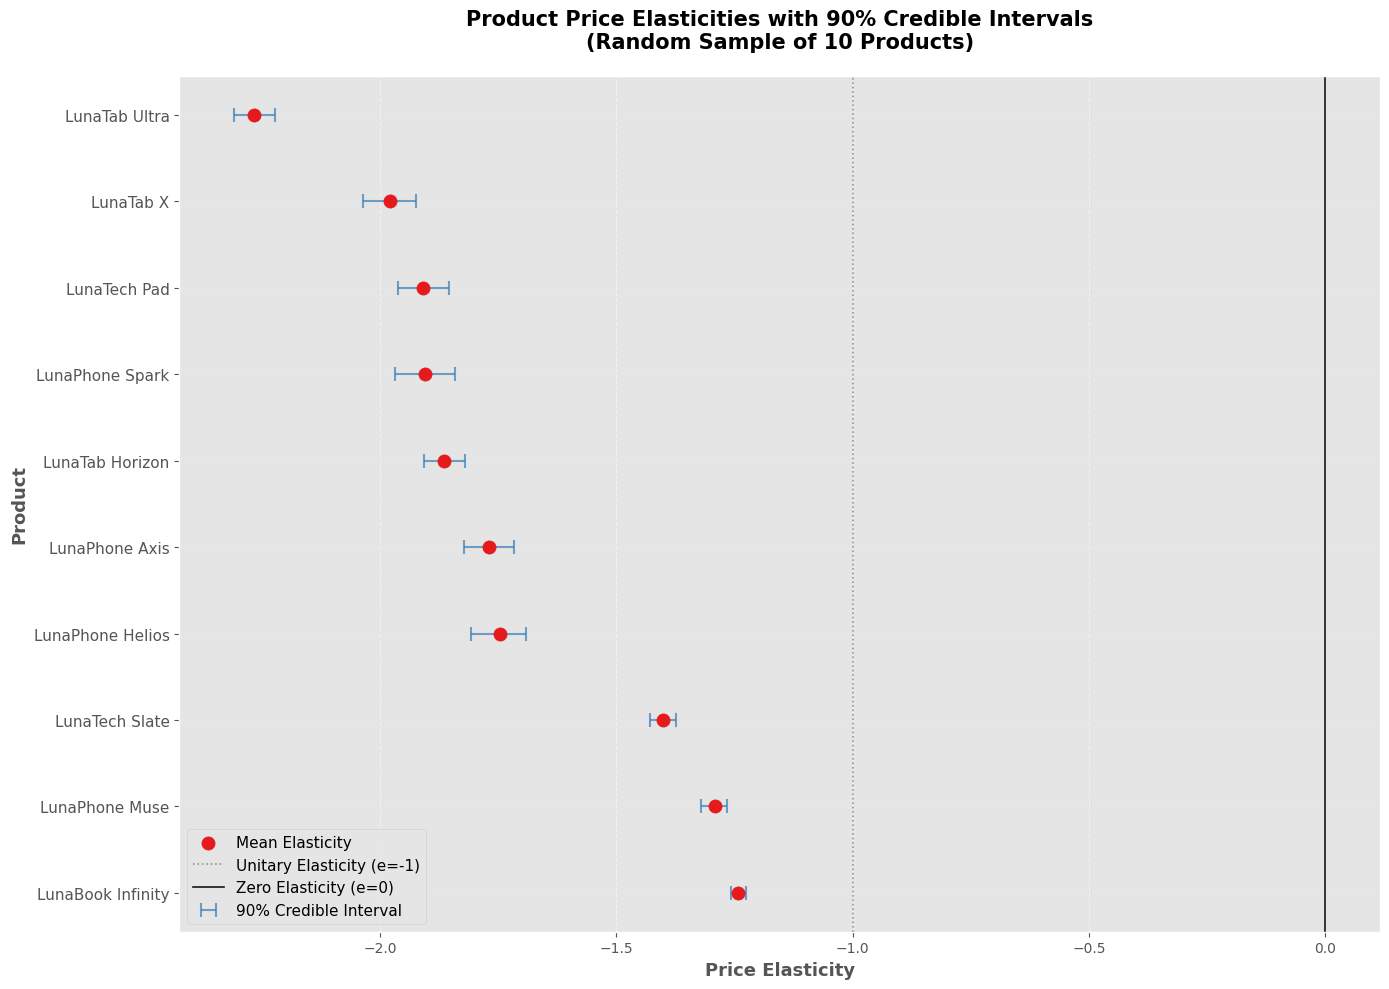

In [27]:
# 4. Product elasticities plot - showing 10 random products
plt.style.use("ggplot")

# Select 10 random products
np.random.seed(42)  # For reproducibility
if len(product_df) >= 10:
    random_products_df = product_df.sample(n=10, random_state=42)
else:
    print(
        f"Warning: Fewer than 10 products available. Plotting all {len(product_df)} products."
    )
    random_products_df = product_df.copy()

random_products_df = random_products_df.sort_values(
    by="mean_elasticity", ascending=True
).reset_index(drop=True)


plt.figure(figsize=(14, 10))
y_pos = np.arange(len(random_products_df))

# Calculate asymmetric errors for xerr
xerr_lower = random_products_df["mean_elasticity"] - random_products_df["lower_ci"]
xerr_upper = random_products_df["upper_ci"] - random_products_df["mean_elasticity"]

xerr_asymmetric = [xerr_lower.to_numpy(), xerr_upper.to_numpy()]

mean_color = "#e41a1c"
ci_color = "#377eb8"

plt.errorbar(
    x=random_products_df["mean_elasticity"],
    y=y_pos,
    xerr=xerr_asymmetric,
    fmt="none",
    capsize=5,
    color=ci_color,
    elinewidth=1.5,
    capthick=1.5,
    alpha=0.7,
    label="90% Credible Interval",
)

# Plot mean elasticity points separately for distinct styling
plt.scatter(
    x=random_products_df["mean_elasticity"],
    y=y_pos,
    color=mean_color,
    s=90,
    label="Mean Elasticity",
    zorder=5,
)

# Reference lines
plt.axvline(
    x=-1,
    color="grey",
    linestyle=":",
    linewidth=1.2,
    alpha=0.8,
    label="Unitary Elasticity (e=-1)",
)
plt.axvline(
    x=0,
    color="black",
    linestyle="-",
    linewidth=1.2,
    alpha=0.9,
    label="Zero Elasticity (e=0)",
)

plt.yticks(y_pos, random_products_df["product"], fontsize=11)
plt.xlabel("Price Elasticity", fontsize=13, fontweight="bold")
plt.ylabel("Product", fontsize=13, fontweight="bold")
plt.title(
    "Product Price Elasticities with 90% Credible Intervals\n(Random Sample of 10 Products)",
    fontsize=15,
    fontweight="bold",
    pad=20,
)

plt.legend(fontsize=11, loc="best")

plt.grid(True, which="major", axis="x", alpha=0.5, linestyle="--")
plt.grid(True, which="major", axis="y", alpha=0.2, linestyle=":")

if len(random_products_df) > 0:
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()